# Inception Model Introduction

### Part I. Introduction

本章介绍如何使用 pre-trained Inception v3 模型来进行图像分类

即使在价值 3万美元的 8 Tesla K40 GPUs 机器上， Inception v3 模型也要花费数周的时间来训练，故此这里直接下载训练好的模型来使用

Inception v3 模型有 25 million 左右的参数，即使在分类一个图片时，也要进行 5 billion 次的 multiply-add 操作

##### Flowchart

Inception model 的详细介绍参见论文 [research paper](http://arxiv.org/pdf/1512.00567v3.pdf)，最近该模型升级了，新模型见 [Newer models](https://research.googleblog.com/2016/08/improving-inception-and-image.html)，比起 v3 更加的复杂，也在分类上取得了些许的提高

Inception model 的 flowchar 如下图，看到红色块为两个 softmax-outputs，下方的一个是用于训练中的输出，而右边的一个是训练后进行分类的输出，也叫做 inference.

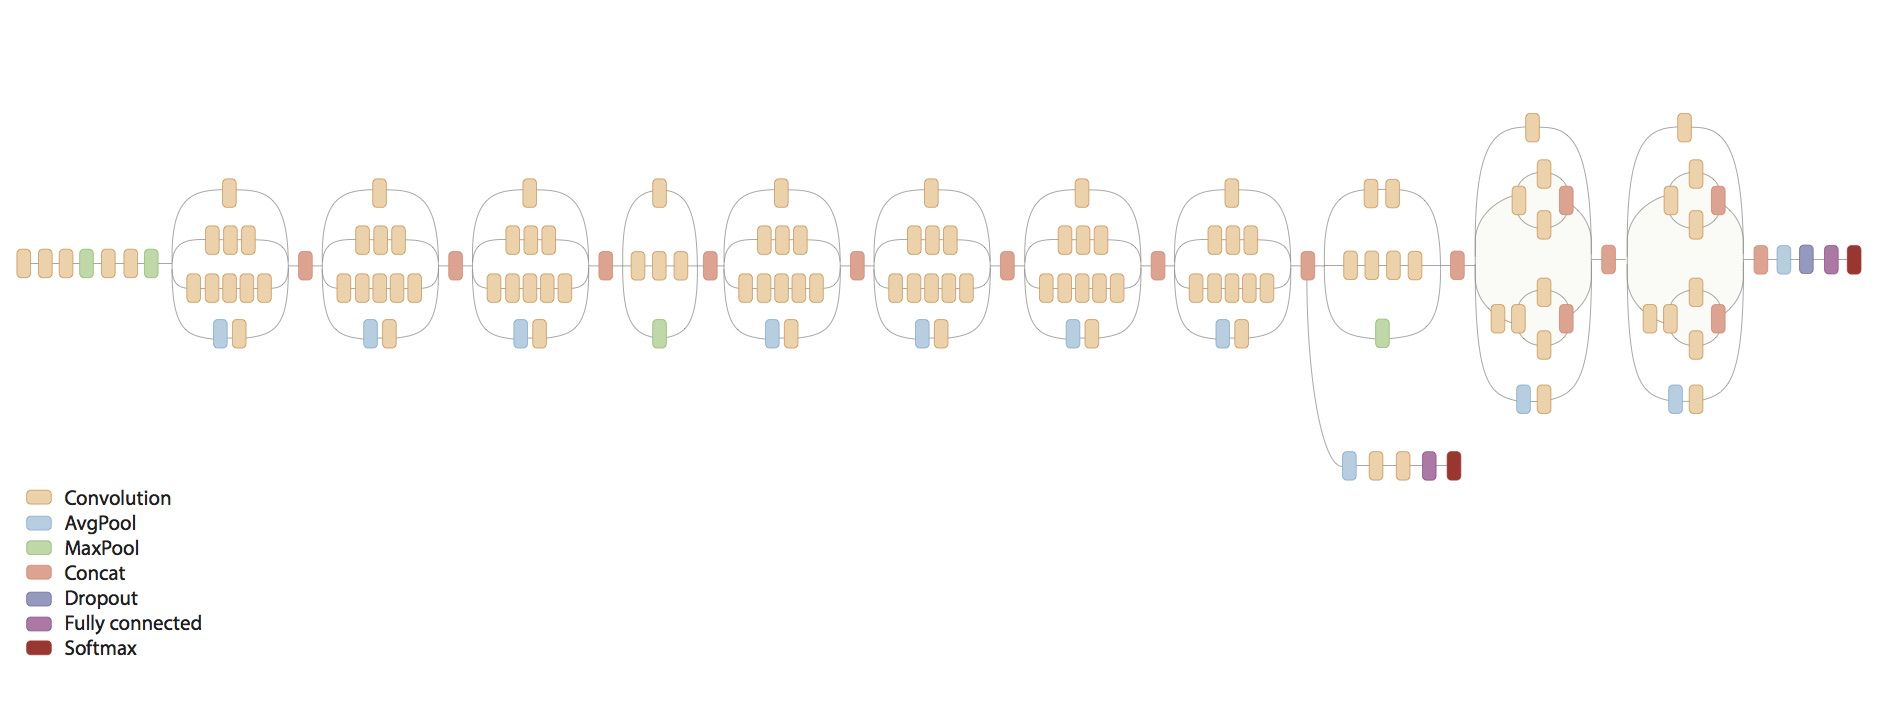

In [1]:
from IPython.display import Image, display
Image('images/07_inception_flowchart.png')

### Part II. 研究模型

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
import inception

In [3]:
tf.__version__

'0.9.0'

我已经预先下载好了 85 MB 大小的模型，并解压到 inception/ 子目录，包括模型的 protobuf 编码文件、 imagenet 竞赛图片的分类值和标签对比表、以及标签及其具体含义的对比表；前面 import 的 inception.py 是笔者实现的 inception 模型操作类，实现了分类值、标签、标签含义的对应函数、Inception 模型预测、模型参数及结果的抽取等函数

In [4]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


##### Load the Inception Model

In [5]:
model = inception.Inception()

In [6]:
# 使用 Inception model 预测图片分类
def classify(image_path):
    display(Image(image_path))
    pred = model.classify(image_path=image_path)
    model.print_scores(pred=pred, k=10, only_first_name=True)     # Inception 一些标签对应多个 name

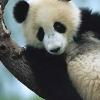

89.23% : giant panda
 0.86% : indri
 0.26% : lesser panda
 0.14% : custard apple
 0.11% : earthstar
 0.08% : sea urchin
 0.05% : forklift
 0.05% : soccer ball
 0.05% : go-kart
 0.05% : digital watch


In [7]:
# 熊猫是 Inception 自带的图片
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')
classify(image_path)

##### 看看自带的 Parrot 图片 （也叫 macaw，即大鹦鹉)

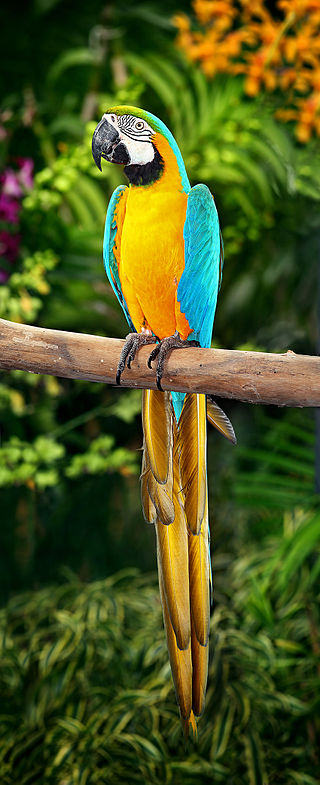

97.30% : macaw
 0.07% : African grey
 0.07% : toucan
 0.05% : jacamar
 0.04% : bee eater
 0.04% : lorikeet
 0.02% : sulphur-crested cockatoo
 0.02% : jay
 0.01% : kite
 0.01% : sandbar


In [8]:
classify(image_path="images/parrot.jpg")

注意， Inception model 要求 input images 为 299 x 299 pixels，上面的图片呢则是 320 x 785 pixels，此时 Inception Model 会自动做 resized，其实就是变形为 299 x 299 

inception.py 中通过 self.session.run(self.resized_image, feed_dict=xxx) 从 Inception model 中抽取出了自动做 resize 的操作，展示如下

In [9]:
def plot_resized_image(image_path):
    resized_image = model.get_resized_image(image_path=image_path)
    plt.imshow(resized_image, interpolation='nearest')
    plt.show()

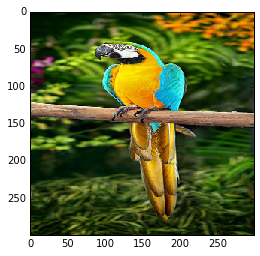

In [10]:
plot_resized_image(image_path="images/parrot.jpg")

前面我们做 cifar-10 的图像分类时，对 32 x 32 的训练图像做了一些调整，比如 crop / flip / 调整对比度、饱和度等，这些是 CNN 图像训练中非常常见的处理，叫做 image augmentation，对丰富数据集有很大帮助。

简单的做 crop 可能会坏事，比如下面 crop 出了尾巴 ...

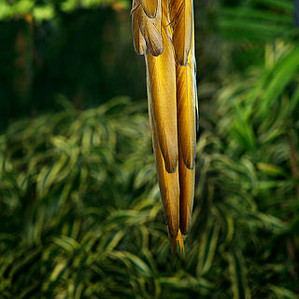

26.11% : jacamar
10.61% : grasshopper
 4.05% : chime
 2.24% : bulbul
 2.00% : fountain pen
 1.60% : leafhopper
 1.26% : cricket
 1.25% : kite
 1.13% : macaw
 0.80% : torch


In [11]:
classify(image_path="images/parrot_cropped3.jpg")

最好的方法是做 padding，就是在两边加空白，调整为正方形，作为原图像再给 Inception model 做 resize

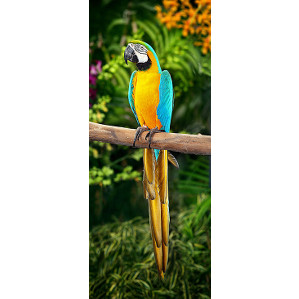

96.78% : macaw
 0.06% : toucan
 0.06% : African grey
 0.05% : bee eater
 0.04% : sulphur-crested cockatoo
 0.03% : king penguin
 0.03% : jacamar
 0.03% : lorikeet
 0.01% : kite
 0.01% : anemone fish


In [12]:
classify(image_path="images/parrot_padded.jpg")

##### 预测人像是 Inception model 的弱点

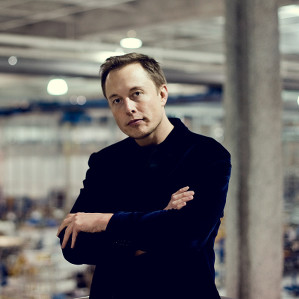

19.73% : sweatshirt
16.82% : abaya
 4.17% : suit
 3.46% : trench coat
 3.05% : ping-pong ball
 1.92% : cellular telephone
 1.86% : baseball
 1.77% : jersey
 1.54% : kimono
 1.43% : water bottle


In [13]:
classify(image_path="images/elon_musk.jpg")

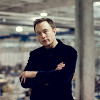

17.85% : sweatshirt
16.36% : cowboy boot
10.68% : balance beam
 8.87% : abaya
 5.36% : suit
 4.57% : Loafer
 2.94% : trench coat
 2.65% : maillot
 1.87% : jersey
 1.42% : unicycle


In [14]:
classify(image_path="images/elon_musk_100x100.jpg")

看到 Inception 并不能看出这是个人像、男人之类的，看到的是 sweat shirt

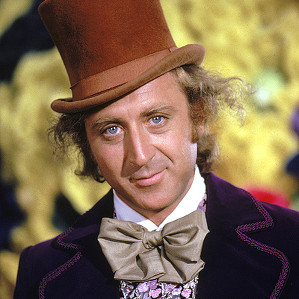

97.22% : bow tie
 0.92% : cowboy hat
 0.21% : sombrero
 0.09% : suit
 0.06% : bolo tie
 0.05% : Windsor tie
 0.04% : cornet
 0.03% : flute
 0.02% : banjo
 0.02% : revolver


In [15]:
classify(image_path="images/willy_wonka_old.jpg")

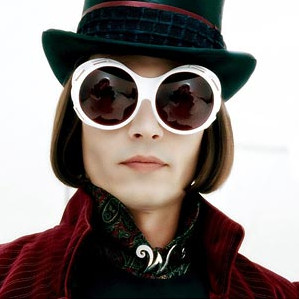

31.48% : sunglasses
18.77% : sunglass
 1.55% : velvet
 1.02% : wig
 0.77% : cowboy hat
 0.69% : seat belt
 0.67% : sombrero
 0.62% : jean
 0.46% : poncho
 0.43% : jersey


In [16]:
classify(image_path="images/willy_wonka_new.jpg")

In [17]:
model.close()

请查看 inception.py 的代码，看如何使用 Inception model 来做图像处理和预测